In [1]:
import numpy as np
from mne import create_info
from mne.io import RawArray

from mne_hfo import (RMSDetector, compute_chs_hfo_rates,
                     events_to_annotations)
from mne_hfo.simulate import simulate_hfo

In [2]:
# simulate the testing dataset
freqs = [2.5, 6.0, 10.0, 16.0, 32.5, 67.5, 165.0,
         250.0, 425.0, 500.0, 800.0, 1500.0]

# sampling frequency
sfreq = 2000

# number of seconds to simulate
n = sfreq * 10
data = np.zeros(n)

# generate some sinusoidal data at specified frequencies
x = np.arange(n)
for freq in freqs:
    # freq_amp = basic_amp / freq
    y = np.sin(2 * np.pi * freq * x / sfreq)
    data += y

# We have dummy data now inject 2 HFOs
freq = 250
numcycles = 9
sim = simulate_hfo(sfreq, freq, numcycles)[0]
ev_start = sfreq
data[ev_start: ev_start + len(sim)] += sim * 10

sim = simulate_hfo(sfreq, freq, numcycles)[0]
ev_start = 7 * sfreq
data[ev_start: ev_start + len(sim)] += sim * 10

# convert the data into mne-python
# note: the channel names are made up and the channel types are just
# set to 'seeg' for the sake of the example
ch_names = ['A1']
info = create_info(sfreq=sfreq, ch_names=ch_names, ch_types='seeg')
raw = RawArray(data=data[np.newaxis, :], info=info)

Creating RawArray with float64 data, n_channels=1, n_times=20000
    Range : 0 ... 19999 =      0.000 ...     9.999 secs
Ready.


Using matplotlib as 2D backend.


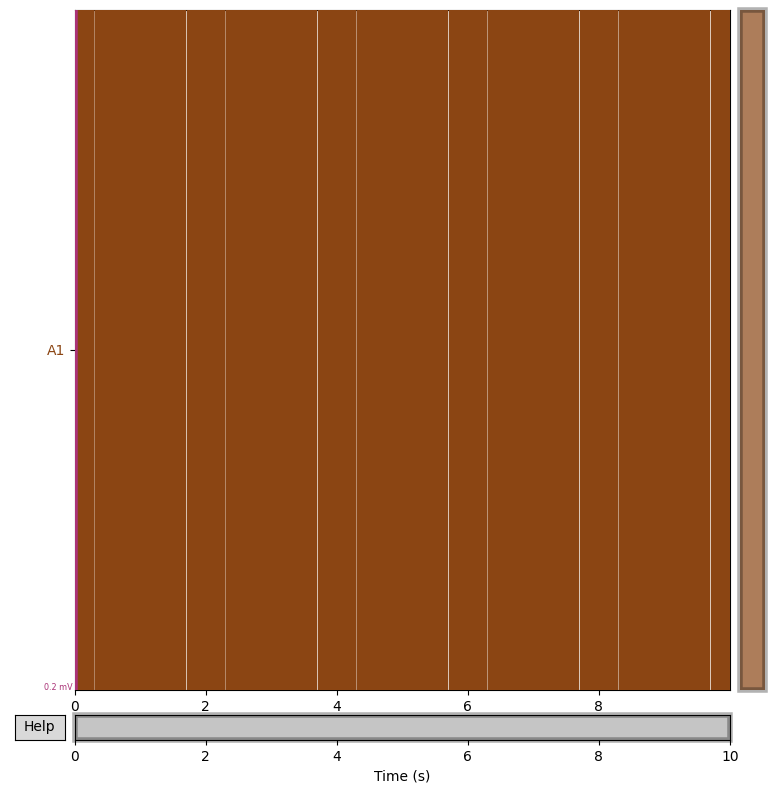

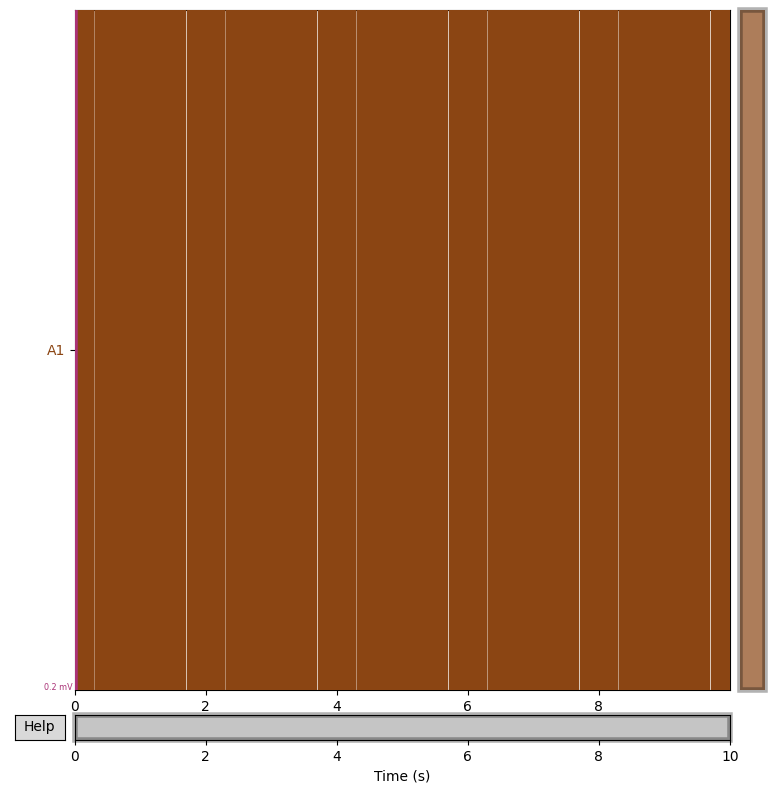

In [3]:
raw.plot()

In [4]:
kwargs = {
    'threshold': 3,  # threshold for "significance"
    'win_size': 100,  # window size in samples
    'overlap': 0.25  # overlap in percentage relative to the window size
}
detector = RMSDetector(**kwargs)

# run detector
detector.fit(X=raw)

# get the event dataframe
event_df = detector.hfo_event_df
print(event_df.head())

100%|██████████| 1/1 [00:00<00:00, 19.16it/s]


TerminatedWorkerError: A worker process managed by the executor was unexpectedly terminated. This could be caused by a segmentation fault while calling the function or by an excessive memory usage causing the Operating System to kill the worker.


In [ ]:
# convert event df -> annotation df
annot_df = events_to_annotations(event_df)
print(annot_df.head())

   onset  duration label channels   sample
0    1.0     0.075   hfo       A1   2000.0
1    7.0     0.075   hfo       A1  14000.0


In [ ]:
ch_rates = compute_chs_hfo_rates(annot_df=annot_df, rate='s')
print(ch_rates)

Beginning timestamp: 2023-07-23 22:53:26.680845+00:00
Got end timestamp of: 2023-07-23 22:53:33.680845+00:00
Found HFO rate per s for A1 as 0.2857142857142857
defaultdict(<class 'list'>, {'A1': 0.2857142857142857})


/usr/local/lib/python3.10/dist-packages/mne_hfo/posthoc.py:112: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for idx, group in annot_df.groupby(['channels']):
